In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.io as sio
import nibabel as nib

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

from statannotations.Annotator import Annotator

from nilearn import plotting
from nilearn.image import new_img_like

sns.set_theme(style="ticks", context="paper", palette="Set2")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def load_roi(dataPath = "results/AnitaBrain5/"):
    ROIs = nib.load(dataPath+"Thickness_1mm_AllRegions.nii").get_fdata().astype("int")
    data = {"ROI":ROIs.flatten()}
    df = pd.DataFrame(data=data)
    df['ROI'] = df['ROI'].astype("category")

    df['ROI'] = df['ROI'].cat.rename_categories(
        {   60:'Putamen L', 125:'Putamen R',
            62:'Globus pallidus L', 127:'Globus pallidus R',
            56:'Red nucleus L', 121:'Red nucleus R',
            57:'Substantia nigra L', 122:'Substantia nigra R',
            61:'Thalamus L', 126:'Thalamus R',
            59:'Caudate Nucleus L', 124:'Caudate Nucleus R',
            145:'Sub-striatum WM L', 146:'Sub-striatum WM R',
            29:'Corticospinal tract L',94:'Corticospinal tract R',
            49:'Pontine crossing tract L', 114:'Pontine crossing tract R',
            135:'Optic tract L', 136:'Optic tract R',
            46:'Sagittal stratum L', 111:'Sagittal stratum R',
            30:'Inferior cerebellar peduncle L', 95:'Inferior cerebellar peduncle R',
            32:'Superior cerebellar peduncle L', 97:'Superior cerebellar peduncle R',
            50:'Middle cerebellar peduncle L', 115:'Middle cerebellar peduncle R',
            33:'Cerebral peduncle L', 98:'Cerebral peduncle R',
            52:'Corpus callosum genu L', 117:'Corpus callosum genu R',
            53:'Corpus callosum body L', 118:'Corpus callosum body R',
            54:'Corpus callosum splenium L', 119:'Corpus callosum splenium R',
            42:'Fornix L', 107:'Fornix R',
            48:'Uncinate fasciculus L', 113:'Uncinate fasciculus R',
            43:'Superior longitudinal fasciculus L', 108:'Superior longitudinal fasciculus R',
            44:'Superior fronto-occipital fasciculus L', 109:'Superior fronto-occipital fasciculus R',
            45:'Inferior fronto-occipital fasciculus L', 110:'Inferior fronto-occipital fasciculus R',
            137:'Lenticular fasciculus L', 138:'Lenticular fasciculus R',} )
    label = 'Others'
    df['ROI'] = df['ROI'].cat.add_categories([label])
    df['ROI'].iloc[df['ROI'].isin(range(165))] = label
    df['ROI'] = df['ROI'].cat.remove_unused_categories()
    # df = df.loc[~df['ROI'].str.match(label)]

    combinedLabels = {   
        'Putamen': ['Putamen L', 'Putamen R'], 
        'Globus pallidus': ['Globus pallidus L', 'Globus pallidus R'], 
        'Red nucleus': ['Red nucleus L', 'Red nucleus R'], 
        'Thalamus': ['Thalamus L', 'Thalamus R'], 
        'Caudate': ['Caudate Nucleus L', 'Caudate Nucleus R'], 
        'Substantia nigra': ['Substantia nigra L', 'Substantia nigra R'],
        'White Matter': ['Sub-striatum WM L', 'Sub-striatum WM R',
                        'Corticospinal tract L','Corticospinal tract R',
                        'Pontine crossing tract L', 'Pontine crossing tract R',
                        'Optic tract L', 'Optic tract R',
                        'Sagittal stratum L', 'Sagittal stratum R',
                        'Inferior cerebellar peduncle L', 'Inferior cerebellar peduncle R',
                        'Superior cerebellar peduncle L', 'Superior cerebellar peduncle R',
                        'Middle cerebellar peduncle L', 'Middle cerebellar peduncle R',
                        'Cerebral peduncle L', 'Cerebral peduncle R',
                        'Corpus callosum genu L', 'Corpus callosum genu R',
                        'Corpus callosum body L', 'Corpus callosum body R',
                        'Corpus callosum splenium L', 'Corpus callosum splenium R',
                        'Fornix L', 'Fornix R',
                        'Uncinate fasciculus L', 'Uncinate fasciculus R',
                        'Superior longitudinal fasciculus L', 'Superior longitudinal fasciculus R',
                        'Superior fronto-occipital fasciculus L', 'Superior fronto-occipital fasciculus R',
                        'Inferior fronto-occipital fasciculus L', 'Inferior fronto-occipital fasciculus R',
                        'Lenticular fasciculus L', 'Lenticular fasciculus R'],
            'Others': ['Others'],
        }
    combinedMapping = {v: k for k, vv in combinedLabels.items() for v in vv}
    df.ROI = df.ROI.map(combinedMapping).astype('category')
    return df

def load_roi_challenge():
    ROIs = nib.load('data/ChallengeSim2SNR1/Segmentation.nii.gz').get_fdata().astype("int")
    data = {'ROI':ROIs.flatten()}
    df = pd.DataFrame(data=data)
    df['ROI'] = df['ROI'].astype('category')

    df['ROI'] = df['ROI'].cat.rename_categories(
        {   1:'Caudate',
            2:'Globus pallidus',
            3:'Putamen',
            4:'Red nucleus',
            5:'Deep nucleus',
            6:'Substantia nigra',#'Substantia nigra and Subthalamic nucleus'
            7:'Thalamus',
            8:'White Matter',
            9:'Gray Matter',
            10:'CSF',
            11:'Blood',
            12:'Fat',
            13:'Bone',
            14:'Air',
            15:'Muscle',
            16:'Calcification'} )
    return df

In [3]:
def load_data(dataPath = "results/AnitaBrain5/", Dataset=5, ROI=None):
    if ROI is None:
        ROIs = nib.load(dataPath+"Thickness_1mm_AllRegions.nii").get_fdata().astype("int").flatten()
    IS = nib.load(dataPath+"ikd_defaults.nii.gz").get_fdata().flatten()
    NDI = nib.load(dataPath+"ndi_defaults.nii.gz").get_fdata().flatten()
    TKD = nib.load(dataPath+"tkd_defaults.nii.gz").get_fdata().flatten()
    nlTV = nib.load(dataPath+"nltv_W_lambda_1.0e-5.nii.gz").get_fdata().flatten()
    CS = nib.load(dataPath+"cs_L1_1.0e-5_delta_0.25.nii.gz").get_fdata().flatten()
    ISreg = nib.load(dataPath+"ikdrReg_L1_1.0e-5_delta_0.25.nii.gz").get_fdata().flatten()

    if ROI is not None:
        interestingROI = (~ROI.ROI.str.match("Others").astype("bool")).to_list()
        IS = IS[interestingROI]
        ISreg = ISreg[interestingROI]
        CS = CS[interestingROI]
        TKD = TKD[interestingROI]
        NDI = NDI[interestingROI]
        nlTV = nlTV[interestingROI]
        ROIs = ROI.loc[interestingROI].ROI.to_list()
        
    data = {"Susceptibility":IS, 'ReconType':"IS", 'Dataset':Dataset, 'ROI':ROIs}
    df1 = pd.DataFrame(data=data)
    data = {"Susceptibility":NDI, 'ReconType':"NDI", 'Dataset':Dataset, "ROI":ROIs}
    df2 = pd.DataFrame(data=data)
    data = {"Susceptibility":nlTV, 'ReconType':"nlTV", 'Dataset':Dataset, "ROI":ROIs}
    df3 = pd.DataFrame(data=data)
    data = {"Susceptibility":TKD, 'ReconType':"TKD", 'Dataset':Dataset, "ROI":ROIs}
    df4 = pd.DataFrame(data=data)
    data = {"Susceptibility":CS, 'ReconType':"CS", 'Dataset':Dataset, "ROI":ROIs}
    df5 = pd.DataFrame(data=data)
    data = {"Susceptibility":ISreg, 'ReconType':"ISreg", 'Dataset':Dataset, "ROI":ROIs}
    df6 = pd.DataFrame(data=data)

    df = pd.concat((df1,df2,df3,df4,df5,df6))

    df['ROI'] = df['ROI'].astype("category")
    df["ReconType"] = df["ReconType"].astype("category")
    return df

def load_data_challenge():
    ROI = load_roi_challenge()
    IS = nib.load("results/Challenge/ikd_defaults.nii.gz").get_fdata().flatten()
    NDI = nib.load("results/Challenge/ndi_defaults.nii.gz").get_fdata().flatten()
    TKD = nib.load("results/Challenge/tkd_defaults.nii.gz").get_fdata().flatten()
    nlTV = nib.load("results/Challenge/nltv_W_lambda_1.0e-5.nii.gz").get_fdata().flatten()
    CS = nib.load("results/Challenge/cs_L1_1.0e-5_delta_0.25.nii.gz").get_fdata().flatten()
    ISreg = nib.load("results/Challenge/ikdrReg_L1_1.0e-5_delta_0.25.nii.gz").get_fdata().flatten()
    
    ROIs = ROI.ROI.to_list()

    data = {"Susceptibility":IS, 'ReconType':"IS", 'Dataset':"Challenge", 'ROI':ROIs}
    df1 = pd.DataFrame(data=data)
    data = {"Susceptibility":NDI, 'ReconType':"NDI", 'Dataset':"Challenge", "ROI":ROIs}
    df2 = pd.DataFrame(data=data)
    data = {"Susceptibility":nlTV, 'ReconType':"nlTV", 'Dataset':"Challenge", "ROI":ROIs}
    df3 = pd.DataFrame(data=data)
    data = {"Susceptibility":TKD, 'ReconType':"TKD", 'Dataset':"Challenge", "ROI":ROIs}
    df4 = pd.DataFrame(data=data)
    data = {"Susceptibility":CS, 'ReconType':"CS", 'Dataset':"Challenge", "ROI":ROIs}
    df5 = pd.DataFrame(data=data)
    data = {"Susceptibility":ISreg, 'ReconType':"ISreg", 'Dataset':"Challenge", "ROI":ROIs}
    df6 = pd.DataFrame(data=data)

    df = pd.concat((df1,df2,df3,df4,df5,df6))

    df['ROI'] = df['ROI'].astype("category")
    df["ReconType"] = df["ReconType"].astype("category")
    return df

In [4]:
dataPath = "results/AnitaBrain5/"
rois = load_roi(dataPath)
df5 = load_data(dataPath, 5, rois)
dataPath = "results/AnitaBrain6/"
rois = load_roi(dataPath)
df6 = load_data(dataPath, 6, rois)
dataPath = "results/AnitaBrain7/"
rois = load_roi(dataPath)
df7 = load_data(dataPath, 7, rois)
dataPath = "results/AnitaBrain8/"
rois = load_roi(dataPath)
df8 = load_data(dataPath, 8, rois)
dataPath = "results/AnitaBrain9/"
rois = load_roi(dataPath)
df9 = load_data(dataPath, 9, rois)

dfInVivo = pd.concat((df5,df6,df7,df8,df9))

In [5]:
dfChallenge = load_data_challenge()

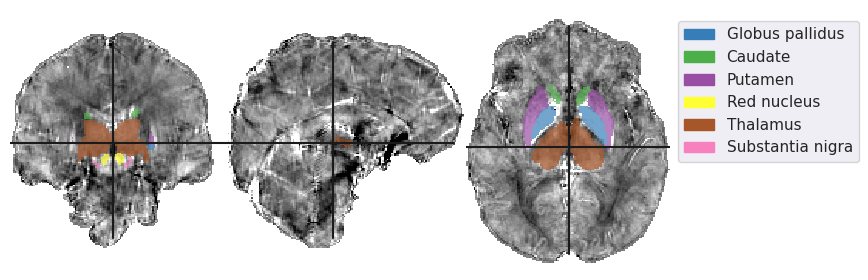

In [9]:
dataPath = "results/AnitaBrain9/"
ROIs = nib.load(dataPath+"Thickness_1mm_AllRegions.nii")
selectedROI = ROIs.get_fdata()
GP = 1*(selectedROI==62) + 1*(selectedROI==127)
Caudate = 2*(selectedROI==59) + 2*(selectedROI==124)
Putamen = 3*(selectedROI==60) + 3*(selectedROI==125)
RN = 4*(selectedROI==56) + 4*(selectedROI==121)
Thalamus = 5*(selectedROI==61) + 5*(selectedROI==126)
SN = 6*(selectedROI==57) + 6*(selectedROI==122)
selectedROI = new_img_like(ROIs, (GP+Caudate+Putamen+RN+Thalamus+SN).astype(np.int32))
                                       
vals = nib.load(dataPath+"ikd_defaults.nii.gz").get_fdata()
vals[vals>0.1] = 0.1
vals[vals<-0.1] = -0.1
vals = new_img_like(ROIs, vals)

cmap = cm.get_cmap('Set1',8)
newcmp = ListedColormap(cmap(range(1,7)))
ax = plotting.plot_roi(selectedROI, bg_img=vals, display_mode='ortho', annotate=False, alpha=0.7, dim=0, black_bg=False, cmap=newcmp)

labels = list(('Globus pallidus','Caudate','Putamen','Red nucleus','Thalamus','Substantia nigra'))
nrois = 6
patches = [mpatches.Patch(color=cmap(i+1), label=labels[i]) for i in range(nrois)]  
plt.legend(handles=patches,bbox_to_anchor=(1,1))


plt.savefig('./figures/InVivo.png', bbox_inches='tight')
plt.show()

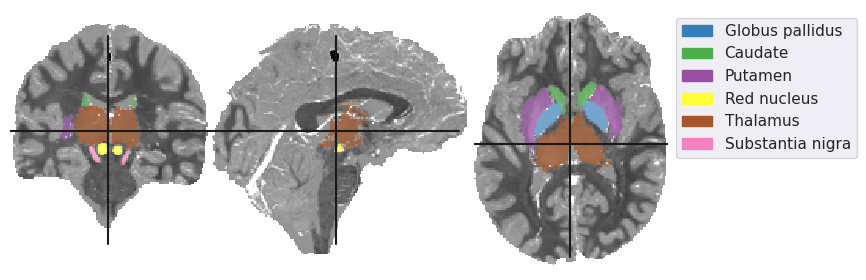

In [10]:
dataPath = "data/ChallengeSim2SNR1/"
ROIs = nib.load(dataPath+"Segmentation.nii.gz")
vals = nib.load(dataPath+"Chi.nii.gz").get_fdata()
mask = nib.load(dataPath+"Brain.nii.gz").get_fdata()

selectedROI = ROIs.get_fdata()
GP = 1*(selectedROI==2)
Caudate = 2*(selectedROI==1)
Putamen = 3*(selectedROI==3)
RN = 4*(selectedROI==4)
Thalamus = 5*(selectedROI==7)
SN = 6*(selectedROI==6)
selectedROI = new_img_like(ROIs, (GP+Caudate+Putamen+RN+Thalamus+SN).astype(np.int32))

vals[vals>0.1] = 0.1
vals[vals<-0.1] = -0.1
vals = new_img_like(ROIs, vals*mask)

cmap = cm.get_cmap('Set1',8)
newcmp = ListedColormap(cmap(range(1,7)))
ax = plotting.plot_roi(selectedROI, bg_img=vals, display_mode='ortho', annotate=False, alpha=0.7, dim=0, black_bg=False, cmap=newcmp)

labels = list(('Globus pallidus','Caudate','Putamen','Red nucleus','Thalamus','Substantia nigra'))
nrois = 6
patches = [mpatches.Patch(color=cmap(i+1), label=labels[i]) for i in range(nrois)]  
plt.legend(handles=patches,bbox_to_anchor=(1,1))


plt.savefig('./figures/Challenge_w_ROIs.png', bbox_inches='tight')
plt.show()

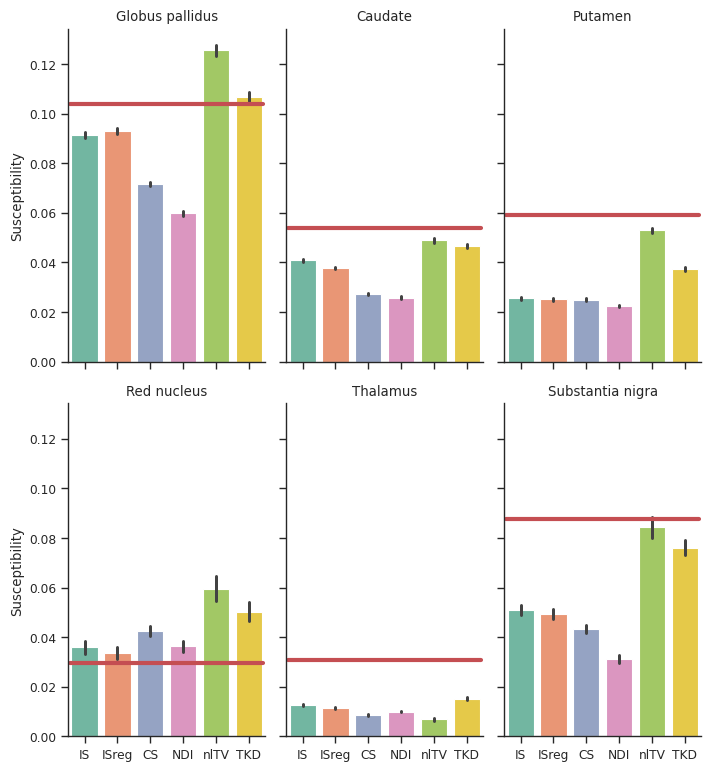

In [11]:
data = dfInVivo
x="ROI"
y="Susceptibility"
hue="ReconType"

hue_order = ["IS", "ISreg", "CS", "NDI", "nlTV", "TKD"]
order = ["Globus pallidus", "Caudate", "Putamen", "Red nucleus", "Thalamus", 
         "Substantia nigra"]

sns.set_theme(style="ticks", context="paper", palette="Set2")
g = sns.catplot(data=data,
            y=y, col=x,  col_order=order, col_wrap=3,
            x=hue, order=hue_order, kind="bar",height=4, aspect=.6,
            errorbar=("se",3),)

ii = 0
# Globus pallidus, Caudate, Putamen, Red nucleus, Thalamus, Substantia nigra, White matter
litVal = (0.1038, 0.0539,0.059,0.0298,0.0308,0.0875,-0.0296)
for ax in g.axes:
    ax.axhline(litVal[ii],0.01,0.99, linewidth=3, color='r')
    ax.set_title(order[ii])
    ax.set_xlabel('')
    ii += 1



plt.savefig('./figures/In_Vivo_ROI.png', bbox_inches='tight')
plt.show()

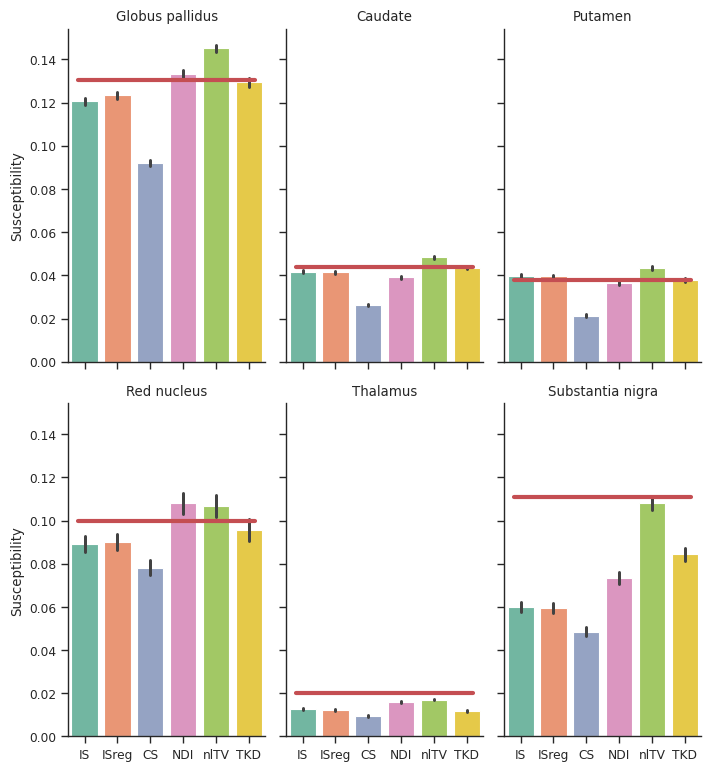

In [12]:
dfChallenge = load_data_challenge()
data = dfChallenge
x="ROI"
y="Susceptibility"
hue="ReconType"

hue_order = ["IS", "ISreg", "CS", "NDI", "nlTV", "TKD"]
order = ["Globus pallidus", "Caudate", "Putamen", "Red nucleus", "Thalamus", 
         "Substantia nigra"]

sns.set_theme(style="ticks", context="paper", palette="Set2")
g = sns.catplot(data=data,
            y=y, col=x,  col_order=order, col_wrap=3,
            x=hue, order=hue_order, kind="bar",height=4, aspect=.6,
            errorbar=("se",3),)

ii = 0
litVal = (0.1305, 0.044,0.038,0.1,0.02,0.111,-0.03)
for ax in g.axes:
    ax.axhline(litVal[ii],0.05,0.95, linewidth=3, color='r')
    ax.set_title(order[ii])
    ax.set_xlabel('')
    ii += 1


plt.savefig('./figures/Challenge_ROI.png', bbox_inches='tight')
plt.show()

In [14]:
dataPath = "results/AnitaBrain6/"
rois = load_roi(dataPath)
df6 = load_data(dataPath, "PDF", rois)
dataPath = "results/AnitaBrain6b/"
rois = load_roi(dataPath[:-2]+"/")
df6b = load_data(dataPath, "V-SHARP", rois)

dfInVivoPDFVSHARP = pd.concat((df6,df6b))

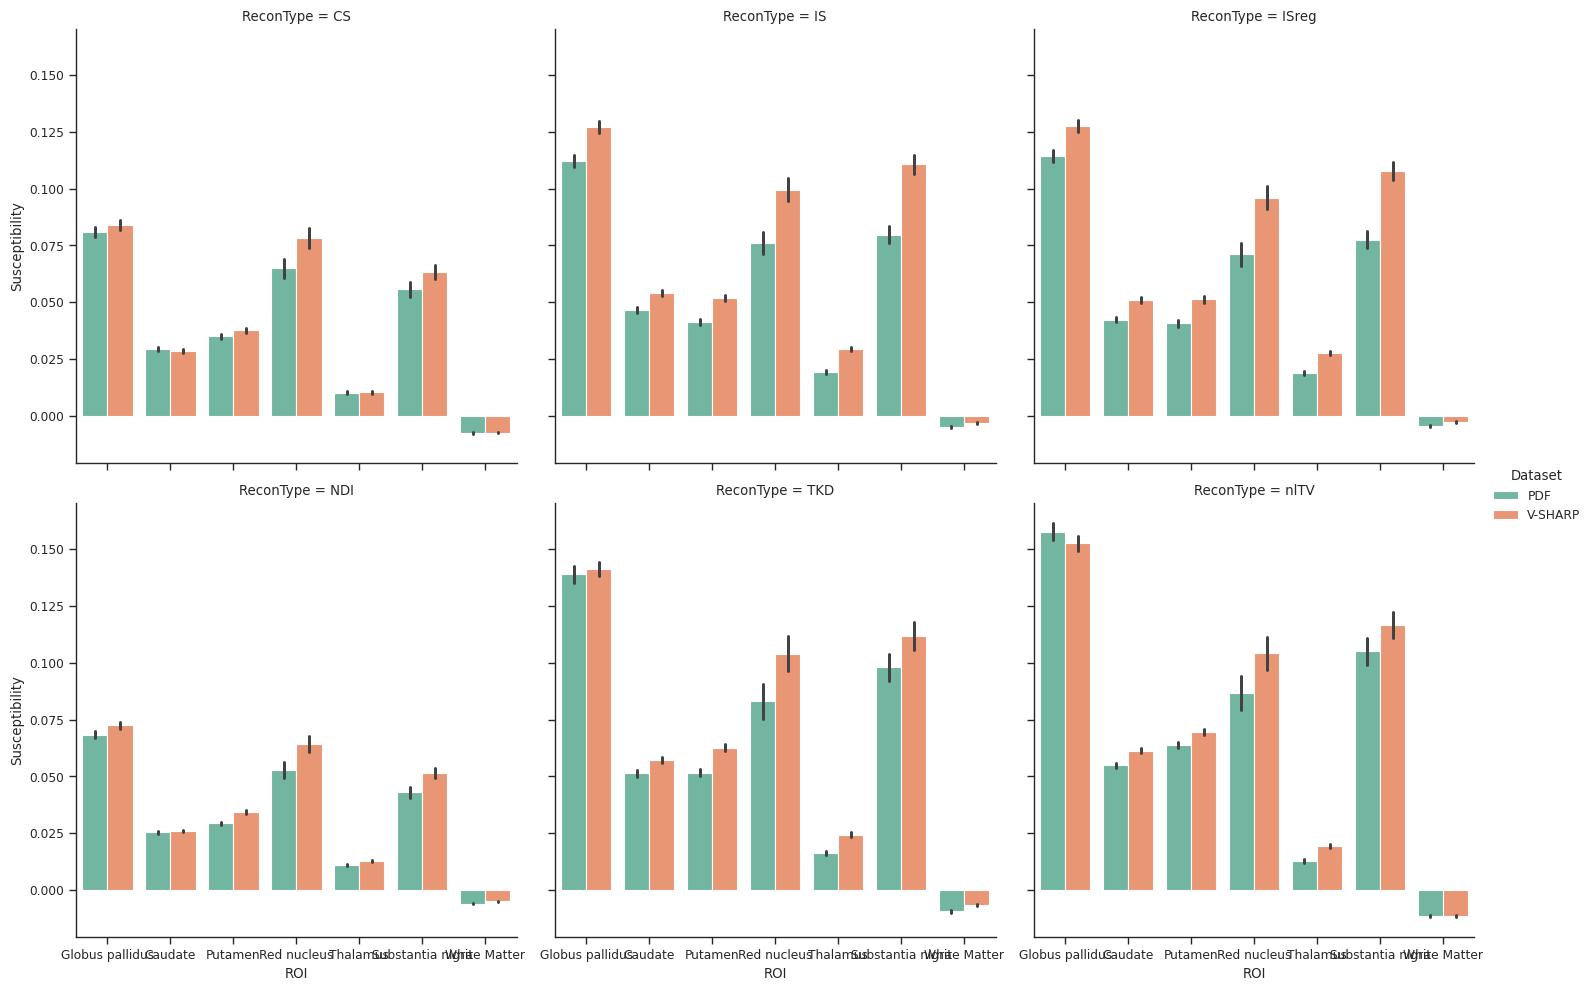

In [15]:
sns.set_theme(style="ticks", context="paper", palette="Set2")
ax = sns.catplot(data=dfInVivoPDFVSHARP,
            y="Susceptibility", x="ROI", order=order, 
            hue="Dataset", kind="bar", col="ReconType", col_wrap=3,
            errorbar=("se",3))

plt.savefig('./figures/In_Vivo_BFR_ROI.png', bbox_inches='tight')
plt.show()

In [16]:
def load_PSNR_v_XSIM():
    ROI = load_roi_challenge()
    PSNR = nib.load("results/Challenge/ikd_delta_0.28.nii.gz").get_fdata().flatten()
    XSIM = nib.load("results/Challenge/ikd_delta_0.24.nii.gz").get_fdata().flatten()

    ROIs = ROI.ROI.to_list()

    data = {"Susceptibility":PSNR, 'ReconType':"IS", 'Dataset':"PSNR", 'ROI':ROIs}
    df1 = pd.DataFrame(data=data)
    data = {"Susceptibility":XSIM, 'ReconType':"IS", 'Dataset':"XSIM", "ROI":ROIs}
    df2 = pd.DataFrame(data=data)

    df = pd.concat((df1,df2))

    df['ROI'] = df['ROI'].astype("category")
    df["ReconType"] = df["ReconType"].astype("category")
    return df
dfPSNRvXSIM = load_PSNR_v_XSIM()

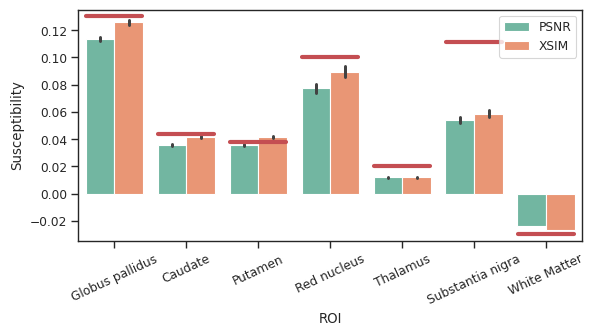

In [17]:
data = dfPSNRvXSIM
sns.set(rc={'figure.figsize':(6.5,3)})
sns.set_theme(style="ticks", context="paper", palette="Set2")
order = ["Globus pallidus", "Caudate", "Putamen", "Red nucleus", "Thalamus", 
         "Substantia nigra", "White Matter"]
ax = sns.barplot(data=data,
            y="Susceptibility", x="ROI", order=order, 
            hue="Dataset", errorbar=("se",3))

litVal = (0.1305, 0.044,0.038,0.1,0.02,0.111,-0.03)
x_min, x_max = ax.get_xlim()
centers = np.array([(centers - x_min)/(x_max - x_min) for centers in ax.get_xticks()])
left = centers - 1/18
right = centers+1/18
for ii in range(7):
        ax.axhline(litVal[ii], left[ii], right[ii], color='r', linewidth=3)

plt.legend(loc='upper right')
plt.xticks(rotation=25)
plt.savefig('./figures/PSNR_v_XSIM_ROI.png', bbox_inches='tight')
plt.show()


In [18]:
dataPath = "results/AnitaBrain5b/"
rois = load_roi(dataPath[:-2]+"/")
df5 = load_data(dataPath, 5, rois)
dataPath = "results/AnitaBrain6b/"
rois = load_roi(dataPath[:-2]+"/")
df6 = load_data(dataPath, 6, rois)
dataPath = "results/AnitaBrain7b/"
rois = load_roi(dataPath[:-2]+"/")
df7 = load_data(dataPath, 7, rois)
dataPath = "results/AnitaBrain8b/"
rois = load_roi(dataPath[:-2]+"/")
df8 = load_data(dataPath, 8, rois)
dataPath = "results/AnitaBrain9b/"
rois = load_roi(dataPath[:-2]+"/")
df9 = load_data(dataPath, 9, rois)

dfInVivoVSHARP = pd.concat((df5,df6,df7,df8,df9))

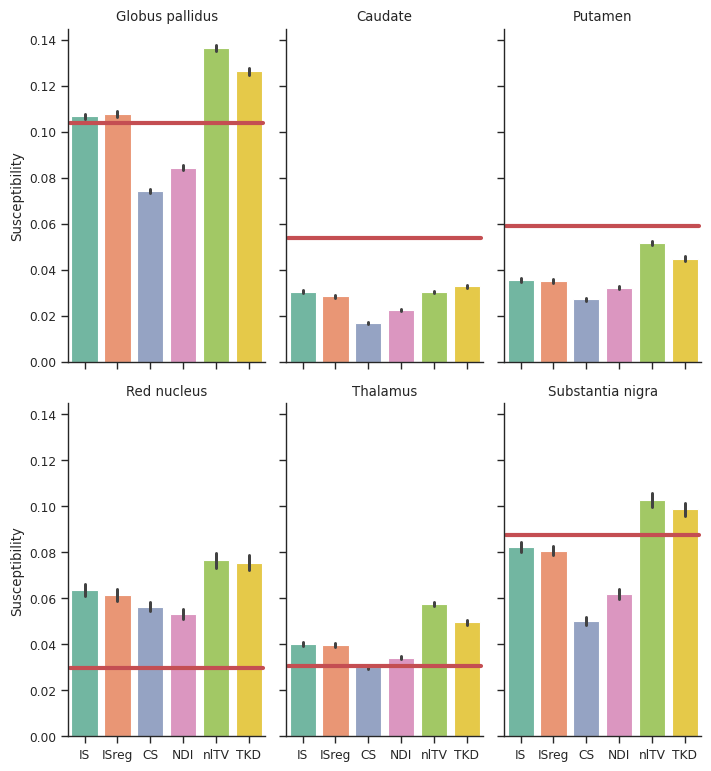

In [ ]:
data = dfInVivoVSHARP
x="ROI"
y="Susceptibility"
hue="ReconType"

hue_order = ["IS", "ISreg", "CS", "NDI", "nlTV", "TKD"]
order = ["Globus pallidus", "Caudate", "Putamen", "Red nucleus", "Thalamus", 
         "Substantia nigra"]

sns.set_theme(style="ticks", context="paper", palette="Set2")
g = sns.catplot(data=data,
            y=y, col=x,  col_order=order, col_wrap=3,
            x=hue, order=hue_order, kind="bar",height=4, aspect=.6,
            errorbar=("se",3),)

ii = 0
# Globus pallidus, Caudate, Putamen, Red nucleus, Thalamus, Substantia nigra, White matter
litVal = (0.1038, 0.0539,0.059,0.0298,0.0308,0.0875,-0.0296)
for ax in g.axes:
    ax.axhline(litVal[ii],0.01,0.99, linewidth=3, color='r')
    ax.set_title(order[ii])
    ax.set_xlabel('')
    ii += 1



plt.savefig('./figures/In_Vivo_ROI_VSHARP.png', bbox_inches='tight')
plt.show()